In [1]:
# Load imports for SportsPose
import torch
import matplotlib.pyplot as plt
from sportspose.dataset import SportsPoseDataset
from sportspose.plot_skeleton_3d import plot_skeleton_3d
from mpl_toolkits.mplot3d import Axes3D

# MotionBert
from lib.model.DSTformer import DSTformer
from functools import partial
import torch.nn as nn
import torch
from collections import OrderedDict

In [2]:
from typing import Any
from sportspose.dataset import SportsPoseDataset
import lightning.pytorch as pl
from lib.model.DSTformer import DSTformer
from functools import partial
from torch import nn, optim, utils
import torch

In [3]:
def reorder_dataparallel_checkpoint(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    return new_state_dict

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Make plot with MPJPE and PA-MPJPE as function of views
views = np.array(range(7)) + 1
mpjpe = np.array([63.761, 27.495, 27.255, 27.497, 26.396, 26.003, 26.859])
pa_mpjpe = np.array([45.699, 16.929, 16.802, 17.862, 16.388, 16.767, 17.084])

fig, ax = plt.subplots()
ax.plot(views, mpjpe, label='MPJPE', linewidth=2)
ax.plot(views, pa_mpjpe, label='PA-MPJPE', linewidth=2)
ax.set_xlabel('Views', fontsize=14)
ax.set_ylabel('Error (mm)', fontsize=14)
#ax.set_title('MPJPE and PA-MPJPE as function of views', fontsize=16)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('debug_images/figs/views.pdf')




In [ ]:
"""
self.key2func = {
    "joints_3d": {
        "data_points": self.idx2joint3d,
        "data_points_full": self.idx2joint3d_full,
    },
    "joints_2d": self.idx2joints2d,  # shape: (measurement, view, joints)
    "video": {
        "image": self.idx2image,
        "calibration": self.idx2calibration,
        "image_names": self.idx2img_name,
        "view": {
            "path": self.idx2image_path},
    },
    "metadata": {
        "file_name": self.idx2name,  # shape: (measurement, )
    },
}
"""

In [4]:
from trackman.posetools.data.datasets import AbstractImageDataset


datapath = "/work3/ckin/bigdata/SportsPose/MarkerlessEndBachelor_withVideoPaths"
videopath = "/work3/ckin/bigdata/SportsPose/videos"
include_debug_images = True

test_subjects = ["S12", "S06", "S19"]
val_subjects = ["S04", "S14", "S22", "S07", "S09"]


return_presets={
        "joints_2d": True,
        "joints_3d": {
            "data_points": True,
        },
        "metadata": {
            "file_name": True,
            "person_id": True,
            "activity": True,
        },
        "video": {
            "view": {
                "camera": False,
                "img_dims": True,
                "numtimesrot90clockwise": True,
            },
            "image": include_debug_images,
            "calibration": True,
        },
    }

dataset = AbstractImageDataset(
            data_dir=datapath,
            dataset_type="sportsPose",
            video_root_dir=videopath,
            views=["FO", "DL"],
            sample_level="video",
            return_preset=return_presets,
            whitelist={
                "metadata": {"person_id": "cin", "activity": "volley"} 
            }, blacklist={"metadata": {"activity": "golf"}}, seq_size=243,
        )

In [5]:
d = dataset[0]

In [11]:
d["video"]["image"]["FO"].shape

(243, 1936, 1216, 3)

In [122]:
import glob
import cv2

for im_path in glob.glob("debug_images/figs/activities/*.png"):
    im = cv2.imread(im_path)
    print(im.shape)
    out = im_path.replace("activities", "activities_small")
    if "_fo" in out:
        cv2.imwrite(out, im[100:-50, 175:-170, :])
    else:
        cv2.imwrite(out, im[90:-60, 175:-170, :])

        
    

(450, 610, 3)
(450, 610, 3)
(450, 610, 3)
(450, 610, 3)
(450, 610, 3)
(450, 610, 3)
(450, 610, 3)
(450, 610, 3)
(450, 610, 3)
(450, 610, 3)


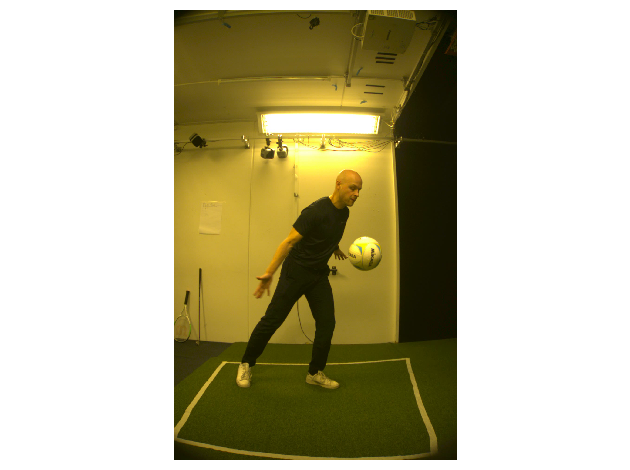

In [100]:
plt.imshow(d["video"]["image"]["DL"][190, :, :])
plt.axis('equal')
plt.axis("off")
plt.tight_layout()
plt.savefig(f"debug_images/figs/activities/{d['metadata']['activity']}_dl.png", bbox_inches="tight", pad_inches=0, transparent=True)

plt.imshow(d["video"]["image"]["FO"][190, :, :])
plt.axis('equal')
plt.axis("off")
plt.tight_layout()
plt.savefig(f"debug_images/figs/activities/{d['metadata']['activity']}_fo.png", bbox_inches="tight", pad_inches=0, transparent=True)


In [ ]:
d["metadata"]["activity"]

In [ ]:
import numpy as np
idx = np.linspace(0, 190, 10, dtype=int)
print(idx)

In [ ]:
1216-1936

In [ ]:
connections = [
    (0, 1),  # Nose to Left eye
    (0, 2),  # Nose to Right eye
    (1, 3),  # Left eye to Left ear
    (2, 4),  # Right eye to Right ear
    (0, 5),  # Nose to Left shoulder
    (5, 7),  # Left shoulder to Left elbow
    (7, 9),  # Left elbow to Left wrist
    (0, 6),  # Nose to Right shoulder
    (6, 8),  # Right shoulder to Right elbow
    (8, 10), # Right elbow to Right wrist
    (5, 11), # Left shoulder to Left hip
    (6, 12), # Right shoulder to Right hip
    (11, 13), # Left hip to Left knee
    (11, 12), # Left hip to right hip
    (12, 14), # Right hip to Right knee
    (13, 15), # Left knee to Left ankle
    (14, 16), # Right knee to Right ankle
]

view = "DL"
for i in idx[-4:]:
    fig = plt.figure()
    #im = np.ones_like(d["video"]["image"]["FO"][190, ...]) * 255
    im = d["video"]["image"][view][i, ...]
    height, width = im.shape[:2]
    plt.imshow(im, alpha=0.0)
    keypoints = d["joints_2d"][view][i, :, :]
    for connection in connections:
        idx1, idx2 = connection
        x1, y1 = keypoints[idx1]
        x2, y2 = keypoints[idx2]
        plt.plot([x1, x2], [y1, y2], color='blue', linewidth=2)
    
    plt.scatter(d["joints_2d"][view][i, :, 0], d["joints_2d"][view][i, :, 1], color="red", s=10)
    plt.axis('equal')
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    #plt.savefig(f"debug_images/figs/{view}_2D_pose_{i}", bbox_inches="tight", pad_inches=0, transparent=True)


In [8]:
model = DSTformer(
            dim_in=3,
            dim_out=3,
            dim_feat=512,
            dim_rep=512,
            depth=5,
            num_heads=8,
            mlp_ratio=2,
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
            maxlen=243,
            num_joints=17,
        )
pretrain_path = "/zhome/0c/6/109332/Projects/MotionBERT/models/model.bin"
if pretrain_path is not None:
            model.load_state_dict(
                reorder_dataparallel_checkpoint(torch.load(pretrain_path)["model_pos"]),
                strict=True,
            )
    

In [ ]:
model_2d_cons.device

In [9]:
from train_sportspose import MotionBertSportPose

checkpoint = "/work3/ckin/motionbert_data/logs/motionbert_sportspose/rvciek39/checkpoints/epoch=29-step=2910.ckpt"
model_2d_cons = MotionBertSportPose.load_from_checkpoint(checkpoint)

checkpoint = "/work3/ckin/motionbert_data/logs/motionbert_sportspose/nr4f6l4n/checkpoints/epoch=29-step=2910.ckpt"
model_2d = MotionBertSportPose.load_from_checkpoint(checkpoint)

checkpoint = "/work3/ckin/motionbert_data/logs/motionbert_sportspose/6yc9468h/checkpoints/epoch=29-step=2910.ckpt"
model_3d = MotionBertSportPose.load_from_checkpoint(checkpoint)

checkpoint = "/work3/ckin/motionbert_data/logs/motionbert_sportspose/o9lc72xw/checkpoints/epoch=29-step=2910.ckpt"
model_3d_cons = MotionBertSportPose.load_from_checkpoint(checkpoint)

# disable randomness, dropout, etc...
model_2d_cons.eval()

# predict with the model
model = model.to("cuda")

In [69]:
train_loader = utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)
batch = next(iter(train_loader))

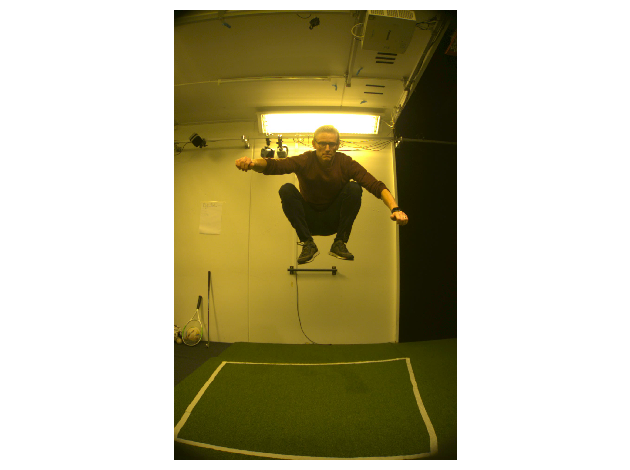

In [71]:
plt.imshow(batch["video"]["image"]["FO"][0, 190, ...])
plt.axis('equal')
plt.axis("off")
plt.tight_layout()
plt.savefig(f"debug_images/figs/diff_figs/im.png", bbox_inches="tight", pad_inches=0, transparent=True)

[101.06827] 58.96875
[130.50421] 62.940285
[30.69899] 20.855425
[11.835927] 7.342721
[9.986182] 8.510033


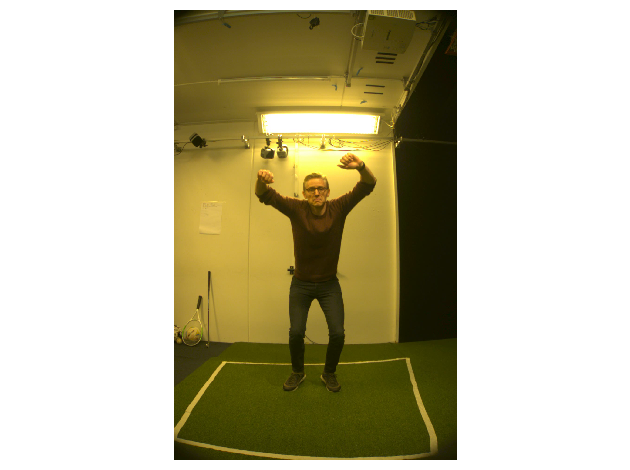

In [70]:
idx = 150
for i, m in enumerate([model, model_2d, model_2d_cons, model_3d, model_3d_cons]):
    plot_3d_diff(m, batch, view="FO", azim=120, rigid_align=False, save_path=f"debug_images/figs/diff_figs/{i}.png", idx=idx)
    plt.close('all')
plt.imshow(batch["video"]["image"]["FO"][0, idx, ...])
plt.axis('equal')
plt.axis("off")
plt.tight_layout()
plt.savefig(f"debug_images/figs/diff_figs/im.png", bbox_inches="tight", pad_inches=0, transparent=True)

In [ ]:
plot_3d_diff(model, batch, view="FO", azim=150, rigid_align=False)

In [ ]:
views = ["FO", "DL"]
outputs = {}
for view in views:
    target3d, j3d_cam, j3d_image = sportspose2h36m(
        batch["joints_3d"]["data_points"],
        batch["video"]["calibration"][view],
        batch["video"][view]["numtimesrot90clockwise"],
        batch["video"][view]["img_dims"],
        return_camera_and_image_coordinates=True,
    )
    pose2d = target3d.clone()
    pose2d[..., 2] = 1.0

    outputs[view] = model(pose2d)

In [ ]:
# Do rigid  transform
 # Unroll sequence
viewDL_unroll = outputs["DL"][0, :, :, :].detach().reshape(-1, 3)
viewFO_unroll = outputs["FO"][0, :, :, :].detach().reshape(-1, 3)

# Compute rigid transformation based on entire sequence
c, R, t = rigid_transform_3D(viewDL_unroll, viewFO_unroll)

viewDL_unroll_aligned = torch.mm(viewDL_unroll, R.t()) * c + t[:, 0]

viewDL_aligned = viewDL_unroll_aligned.reshape(243, 17, 3)

In [ ]:
target3d.shape

In [ ]:
fo_p = outputs["FO"][0, :, :, :].detach()

In [ ]:
viz_j = torch.stack([fo_p[190, ...], viewDL_aligned[190, ...]])

In [59]:
%load_ext autoreload
%autoreload 
import lib.model.loss as losses

def plot_3d_diff(model, batch, view="FO", azim=95, rigid_align=True, idx=190, save_path=None):
    target3d, j3d_cam, j3d_image = sportspose2h36m(
        batch["joints_3d"]["data_points"],
        batch["video"]["calibration"][view],
        batch["video"][view]["numtimesrot90clockwise"],
        batch["video"][view]["img_dims"],
        return_camera_and_image_coordinates=True,
    )
    pose2d = target3d.clone()
    pose2d[..., 2] = 1.0

    output = model(pose2d.to("cuda"))
    # Get denormalized values for MPJPE
    output_denorm = denormalize_dections(
        output,
        batch["video"][view]["img_dims"],
        batch["video"][view]["numtimesrot90clockwise"],
    )

    if rigid_align:
        output_unroll = output[0, :, :, :].detach().cpu().reshape(-1, 3)
        gt_unroll = target3d[0, :, :, :].detach().cpu().reshape(-1, 3)
    
        # Compute rigid transformation based on entire sequence
        c, R, t = rigid_transform_3D(output_unroll, gt_unroll)
        output_unroll_aligned = torch.mm(output_unroll, R.t()) * c + t[:, 0]
    
        output_aligned = output_unroll_aligned.reshape(243, 17, 3)
        viz_j = torch.stack([output_aligned[idx, ...], target3d[0, idx, ...]])
    else:
         # Align by root joint
        test_preds = output_denorm - output_denorm[:, :, 0:1, :]
        gt = j3d_image - j3d_image[:, :, 0:1, :]

        test_preds = test_preds.detach().cpu()
        gt = gt.detach().cpu()

        t_stack = target3d.detach().cpu()
        o_stack = output.detach().cpu()

        t_stack = t_stack - t_stack[:, :, 0:1, :]
        o_stack = o_stack - o_stack[:, :, 0:1, :]
        
        viz_j = torch.stack([t_stack[0, idx, :, :], o_stack[0, idx, :, :]])
        t = test_preds[0, idx, ...].detach().cpu().numpy()
        g = gt[0, idx, ...].detach().cpu().numpy()
        mpjpe = losses.mpjpe(t[None, ...], g[None, ...])
        pampjpe = losses.p_mpjpe(t[None, ...], g[None, ...])
        
   

    data, fig = visualize_3d_pose(viz_j, col=[0,2], azim=azim, plot_diff=True)
    plt.tight_layout()

    print(mpjpe, pampjpe)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0, transparent=True)

    
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
data, fig = visualize_3d_pose(viz_j, col=[0,2], azim=95, plot_diff=True)
plt.tight_layout()
#plt.show()
#plt.savefig(f"debug_images/figs/3D/aligned_red", bbox_inches="tight", pad_inches=0, transparent=True)

In [ ]:

for view, col in zip(views, [0, 2]):
    o = outputs[view][0, :, :, :].detach().cpu().numpy()
    for azim in [10, 40, 70, 95, 100, 130, 150, 180, 210]:
        data, fig = visualize_3d_pose(o[190, ...], color=col, azim=azim)
        plt.tight_layout()
        #plt.show
        plt.savefig(f"debug_images/figs/3D/{view}_azim_{azim}", bbox_inches="tight", pad_inches=0, transparent=True)

In [14]:
from mpl_toolkits.mplot3d import Axes3D, art3d
from matplotlib.patches import FancyArrowPatch
import numpy as np

%load_ext autoreload
%autoreload 2


def rigid_transform_3D(A, B):
    """
    Compute rigid transformation from A to B by Procrustes analysis.
    """
    n, dim = A.shape
    centroid_A = torch.mean(A, dim=0)
    centroid_B = torch.mean(B, dim=0)
    H = torch.mm((A - centroid_A).t(), B - centroid_B) / n
    U, s, V = torch.svd(H)
    R = torch.mm(V, U.t())
    if torch.det(R) < 0:
        V = V.clone()
        s = s.clone()

        s[-1] = -s[-1]
        V[:, 2] = -V[:, 2]

        R = torch.mm(V, U.t())

    varP = torch.var(A, dim=0).sum()
    c = 1 / varP * s.sum()

    t = -torch.mm(c * R, centroid_A.view(3, 1)) + centroid_B.view(3, 1)
    return c, R, t


def visualize_3d_pose(j3ds, col=0, azim=95, plot_diff=False, show_grid=False):
    """
    Plots a 3D skeleton.

    Args:
        j3d (np.array): 3D pose array of shape (J, 3).
    """

    # Human3.6M joint pairs
    joint_pairs = [
        [0, 1],
        [1, 2],
        [2, 3],
        [0, 4],
        [4, 5],
        [5, 6],
        [0, 7],
        [7, 8],
        [8, 9],
        [8, 11],
        [8, 14],
        [9, 10],
        [11, 12],
        [12, 13],
        [14, 15],
        [15, 16],
    ]
    joint_pairs_left = [[8, 11], [11, 12], [12, 13], [0, 4], [4, 5], [5, 6]]
    joint_pairs_right = [[8, 14], [14, 15], [15, 16], [0, 1], [1, 2], [2, 3]]

    fig = plt.figure(0, figsize=(10, 10))
    ax = plt.axes(projection="3d")
    lim_val = 0.7
    ax.set_xlim(-lim_val, lim_val)
    ax.set_ylim(-lim_val, lim_val)
    ax.set_zlim(-lim_val, lim_val)
    ax.set_xlabel("X")
    ax.set_ylabel("Z")
    ax.set_zlabel("Y")
    ax.set_axis_off()  # Hide axes
    ax.view_init(elev=12.0, azim=azim)
    if not show_grid:
        ax.grid(False)  # Disable drawing of 3D grid

    plt.tick_params(
        left=False, right=False, labelleft=False, labelbottom=False, bottom=False
    )
    if j3ds.shape[0] > 10:
        j3ds = j3ds[None, ...]
        col = [col]
    for skel_id in range(j3ds.shape[0]):
        j3d = j3ds[skel_id, ...]
        # Viz colors
        color = col[skel_id]
        if color == 0:  # Nuances of Blue
            #color_mid = "#00457E"
            #color_left = "#02315E"
            #color_right = "#2F70AF"
            color_mid = "#0000BF"
            color_left = "#0000FF"
            color_right= "#4040FF"
        elif color == 1:  # Nuances of Red
            color_mid = "#8B0000"
            color_left = "#610000"
            color_right = "#A52A2A"
        elif color == 2:  # Nuances of Green
            #color_mid = "#006400"
            #color_left = "#73FF00"
            #color_right = "#008000"
            color_mid = "#80ff00"
            color_left = "#00e600"
            color_right = "#1aff1a"
        elif color == 3:
            # Default color if an invalid option is provided
            color_mid = "#FFA940"
            color_left = "#FF8C00"
            color_right = "#FF8C00"
        for i in range(len(joint_pairs)):
            limb = joint_pairs[i]
            xs, ys, zs = [np.array([j3d[limb[0], j], j3d[limb[1], j]]) for j in range(3)]
            if joint_pairs[i] in joint_pairs_left:
                ax.plot(
                    -xs,
                    -zs,
                    -ys,
                    color=color_left,
                    lw=2,
                    marker="o",
                    markerfacecolor="w",
                    markersize=3,
                    markeredgewidth=2,
                )  # axis transformation for visualization
            elif joint_pairs[i] in joint_pairs_right:
                ax.plot(
                    -xs,
                    -zs,
                    -ys,
                    color=color_right,
                    lw=2,
                    marker="o",
                    markerfacecolor="w",
                    markersize=3,
                    markeredgewidth=2,
                )  # axis transformation for visualization
            else:
                ax.plot(
                    -xs,
                    -zs,
                    -ys,
                    color=color_mid,
                    lw=2,
                    marker="o",
                    markerfacecolor="w",
                    markersize=3,
                    markeredgewidth=2,
                )  # axis transformation for visualization
    
    if plot_diff:
        for i in range(j3ds.shape[1]): # For all keypoints
            xs, ys, zs = [np.array([j3ds[0, i, j], j3ds[1, i, j]]) for j in range(3)]
            """
            ax.plot(
                    -xs,
                    -zs,
                    -ys,
                    color="#8B0000",
                    lw=1,
                    marker="o",
                    markerfacecolor="w",
                    markersize=0,
                    markeredgewidth=2,
                )  # axis transformation for visualization
            """
            
            arrow = art3d.Line3D(-xs, -zs, -ys, color="#8B0000",
                lw=2,
                marker="o",
                markerfacecolor="r",
                markersize=3,
                markeredgewidth=1,
                linestyle='dashed'  # Add this line for dashed linestyle
            )
            ax.add_line(arrow)

    
    fig.canvas.draw()

    # Now we can save it to a numpy array.
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Close figure to prevent memory leak
    #plt.close(fig)

    return data, fig

def _infer_box(
    pose3d: torch.tensor, fx: float, fy: float, cx: float, cy: float, rootIdx: int = 0
):
    """
    Infers the bounding box of a 3D pose in 2D space.

    Args:
        pose3d (torch.tensor): A tensor of shape (N, 3) representing the 3D pose.
        intrinsics (dict): A dictionary containing the camera intrinsics.
        rootIdx (int, optional): The index of the root joint. Defaults to 0.

    Returns:
        torch.tensor: A tensor of shape (4,) representing the bounding box in 2D space.
    """
    root_joint = pose3d[rootIdx, :]

    # Top left
    tl_joint = root_joint.clone()
    tl_joint[:2] -= 1000.0

    # Bottom right
    br_joint = root_joint.clone()
    br_joint[:2] += 1000.0
    tl_joint = torch.reshape(tl_joint, (1, 3))
    br_joint = torch.reshape(br_joint, (1, 3))

    # Project to 2D
    tl2d = _weak_project(tl_joint, fx, fy, cx, cy).flatten()

    br2d = _weak_project(br_joint, fx, fy, cx, cy).flatten()

    return torch.tensor([tl2d[0], tl2d[1], br2d[0], br2d[1]])


def _weak_project(pose3d, fx, fy, cx, cy):
    pose2d = pose3d[:, :2] / pose3d[:, 2:3]
    pose2d[:, 0] *= fx
    pose2d[:, 1] *= fy
    pose2d[:, 0] += cx
    pose2d[:, 1] += cy
    return pose2d


def camera2image_coordinates(
    pose3d: torch.tensor,
    box: torch.tensor,
    fx: float,
    fy: float,
    cx: float,
    cy: float,
    rootIdx: int = 0,
):
    rectangle_3d_size = 2000.0
    ratio = (box[2] - box[0] + 1) / rectangle_3d_size
    pose3d_image_frame = torch.zeros_like(pose3d)
    pose3d_image_frame[:, :2] = _weak_project(pose3d.clone(), fx, fy, cx, cy)
    pose3d_depth = ratio * (pose3d[:, 2] - pose3d[rootIdx, 2])
    pose3d_image_frame[:, 2] = pose3d_depth
    return pose3d_image_frame


def rotate_3d_pose_90_clockwise(
    pose3d: torch.tensor,
    numtimesrot90clockwise: int,
):
    """
    Rotates 3D pose in camera coordinates by 90 degrees clockwise while accounting for image dimensions.

    Args:
        pose3d (torch.tensor): 3D pose tensor of shape (S, J, 3).
        numtimesrot90clockwise (int): Number of times to rotate the pose by 90 degrees clockwise.

    Returns:
        torch.tensor: 3D pose tensor of shape (S, J, 3) after rotation.
    """
    pose3d_rotated = pose3d.clone()
    for i in range(numtimesrot90clockwise):
        x = pose3d_rotated[..., 0].clone()
        y = pose3d_rotated[..., 1].clone()
        pose3d_rotated[..., 0] = -y  # + image_height
        pose3d_rotated[..., 1] = x

    return pose3d_rotated


def coco2h36m(x):
    """
    COCO: {0-nose 1-Leye 2-Reye 3-Lear 4Rear 5-Lsho 6-Rsho 7-Lelb 8-Relb 9-Lwri 10-Rwri 11-Lhip 12-Rhip 13-Lkne 14-Rkne 15-Lank 16-Rank}

    H36M:
    0: 'root',
    1: 'rhip',
    2: 'rkne',
    3: 'rank',
    4: 'lhip',
    5: 'lkne',
    6: 'lank',
    7: 'belly',
    8: 'neck',
    9: 'nose',
    10: 'head',
    11: 'lsho',
    12: 'lelb',
    13: 'lwri',
    14: 'rsho',
    15: 'relb',
    16: 'rwri'
    """
    if isinstance(x, torch.Tensor):
        y = torch.zeros_like(x)
    else:
        T, V, C = x.shape
        x = x[None, ...]
        y = np.zeros([1, T, 17, C])

    y[:, :, 0, :] = (x[:, :, 11, :] + x[:, :, 12, :]) * 0.5
    y[:, :, 1, :] = x[:, :, 12, :]
    y[:, :, 2, :] = x[:, :, 14, :]
    y[:, :, 3, :] = x[:, :, 16, :]
    y[:, :, 4, :] = x[:, :, 11, :]
    y[:, :, 5, :] = x[:, :, 13, :]
    y[:, :, 6, :] = x[:, :, 15, :]
    y[:, :, 8, :] = (x[:, :, 5, :] + x[:, :, 6, :]) * 0.5
    y[:, :, 7, :] = (y[:, :, 0, :] + y[:, :, 8, :]) * 0.5
    y[:, :, 9, :] = x[:, :, 0, :]
    y[:, :, 10, :] = (x[:, :, 1, :] + x[:, :, 2, :]) * 0.5
    y[:, :, 11, :] = x[:, :, 5, :]
    y[:, :, 12, :] = x[:, :, 7, :]
    y[:, :, 13, :] = x[:, :, 9, :]
    y[:, :, 14, :] = x[:, :, 6, :]
    y[:, :, 15, :] = x[:, :, 8, :]
    y[:, :, 16, :] = x[:, :, 10, :]

    return y


def sportspose2h36m(
    j3d_world_spostspose: torch.Tensor,
    camera_info: dict,
    times_rot90: int = 0,
    res: tuple = (1920, 1080),
    return_camera_and_image_coordinates: bool = False,
) -> torch.Tensor:
    """
    Converts 3D pose from world coordinates to camera coordinates and then to H36M coordinates.

    Args:
        j3d_world_spostspose (torch.Tensor): 3D pose in world coordinates, of shape (B, S, J, 3) or (S, J, 3) .
        camera_info (dict): Camera information dictionary containing extrinsic parameters.
        times_rot90 (int, optional): Number of times the image is rotated by 90 degrees. Defaults to 0.
        res (tuple, optional): Resolution of the image, of the form (width, height). Defaults to (1920, 1080).
        return_camera_and_image_coordinates (bool, optional): Whether to return the pose in camera and image coordinates. Defaults to False.

    Returns:
        torch.Tensor: 3D pose in H36M coordinates, of shape (B, S, J, 3).
    """
    # Convert to camera coordinates from world coordinates
    rot = camera_info["extrinsic"]["R"].to(j3d_world_spostspose)
    trans = camera_info["extrinsic"]["T"].to(j3d_world_spostspose)

    # Add batch dimension if not present to unify the code
    if len(j3d_world_spostspose.shape) != 4:
        j3d_world_spostspose = j3d_world_spostspose[None, ...]
    b, s, j, _ = j3d_world_spostspose.shape

    # Transform 3d pose to camera coordinate
    world_to_cam = torch.zeros((b, 4, 4), dtype=torch.float64).to(j3d_world_spostspose)
    world_to_cam[:, :3, :3] = rot
    world_to_cam[:, :3, 3] = trans
    world_to_cam[:, 3, 3] = 1.0

    # Pad the world coordinate to 4d homogenous coordinate
    ones_column = torch.ones(*j3d_world_spostspose.shape[:-1], 1).to(
        j3d_world_spostspose
    )
    j3d_world_hom = torch.cat([j3d_world_spostspose, ones_column], dim=-1)

    # Transform to camera coordinate
    j3d_camera = torch.matmul(world_to_cam, j3d_world_hom.view(b, -1, 4).mT).mT
    j3d_camera = (j3d_camera[..., :3] / j3d_camera[..., 3].unsqueeze(-1)).view(
        b, s, j, 3
    )

    # Scale from meter to millimeter
    j3d_camera = j3d_camera * 1000.0

    # Reorder coordinates to match H36M
    j3d_camera = coco2h36m(j3d_camera)

    # Go from camera coordinates to image coordinates
    j3d_image = torch.zeros_like(j3d_camera)
    j3d_image_org = torch.zeros_like(j3d_camera)
    j3d_scaled_image = j3d_image.clone()

    for batch_num in range(b):
        for frame in range(s):
            box = _infer_box(
                j3d_camera[batch_num, frame, :, :],
                fx=camera_info["intrinsic"]["f"][0, 0],
                fy=camera_info["intrinsic"]["f"][0, 1],
                cx=camera_info["intrinsic"]["c"][0, 0],
                cy=camera_info["intrinsic"]["c"][0, 1],
            )

            j3d_image[batch_num, frame] = camera2image_coordinates(
                j3d_camera[batch_num, frame, :, :],
                box,
                fx=camera_info["intrinsic"]["f"][0, 0],
                fy=camera_info["intrinsic"]["f"][0, 1],
                cx=camera_info["intrinsic"]["c"][0, 0],
                cy=camera_info["intrinsic"]["c"][0, 1],
                rootIdx=0,
            )
        j3d_image_org[batch_num, ...] = j3d_image[batch_num, ...].clone()
        res_w, res_h = res[batch_num, ...]
        if times_rot90[batch_num] % 2 == 1:
            res_h, res_w = res[batch_num, ...]
            j3d_image[batch_num, :, :, :] = rotate_3d_pose_90_clockwise(
                j3d_image[batch_num, :, :, :], 1
            )
            j3d_image[batch_num, :, :, 0] += res_w

        # Scale to be within [-1, 1]
        j3d_scaled_image[batch_num, :, :, :] = j3d_image[batch_num, :, :, :]
        j3d_scaled_image[batch_num, :, :, :2] = j3d_scaled_image[
            batch_num, :, :, :2
        ] / res_w * 2 - torch.tensor(
            [
                1,
                res_h / res_w,
            ]
        ).to(
            j3d_scaled_image
        )
        j3d_scaled_image[batch_num, :, :, 2:] = (
            j3d_scaled_image[batch_num, :, :, 2:] / res_w * 2
        )

    if return_camera_and_image_coordinates:
        return j3d_scaled_image.float(), j3d_camera.float(), j3d_image.float()
    return j3d_scaled_image.float()


def denormalize_dections(j3d, res, times_rot90):
    """
    Denormalizes model detections in order to be able to compute a MPJPE score.
    Note that it denormalizes the detections to millimeters and not meters as the original dataset.

    Args:
        j3d (torch.tensor): 3D pose tensor of shape (B, S, J, 3) or (S, J, 3).
        res (tuple): Image resolution of the form (width, height).
        times_rot90 (int): Number of times the image is rotated by 90 degrees.

    Returns:
        torch.tensor: 3D pose tensor of shape (S, J, 3) after denormalization.
    """
    j3d_denorm = j3d.clone()

    # If there is no batch dimension, add one to unify the code
    if len(j3d_denorm.shape) != 4:
        j3d_denorm = j3d_denorm[None, ...]

    for batch_num in range(j3d.shape[0]):
        if times_rot90[batch_num] % 2 == 1:
            res_h, res_w = res[batch_num, ...]
        else:
            res_w, res_h = res[batch_num, ...]

        j3d_denorm[batch_num, :, :, :2] = (
            (
                j3d_denorm[batch_num, :, :, :2]
                + torch.tensor([1, res_h / res_w]).to(j3d_denorm)
            )
            * res_w
            / 2
        )
        j3d_denorm[batch_num, :, :, 2:] = j3d_denorm[batch_num, :, :, 2:] * res_w / 2

    return j3d_denorm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
d = dataset[3]

for i in [100, 110, 120, 180, 190]:
    plt.imshow(d["video"]["image"]["FO"][i, ...])
    plt.axis("off")
    plt.tight_layout()
    #plt.show()    
    plt.savefig(f"debug_images/figs/FO_tennis_{i}", bbox_inches="tight", pad_inches=0)


In [ ]:
subjects = []
for i in range(len(dataset)):
    subjects.append(dataset[i]["metadata"]["person_id"])


In [ ]:
from collections import Counter
string_counts = Counter(subjects)

# Extract unique strings and their counts
unique_strings = list(string_counts.keys())
counts = list(string_counts.values())

# Create a histogram
plt.bar(unique_strings, counts)

# Add labels and title
plt.xlabel("Strings")
plt.ylabel("Count")
plt.title("String Histogram")

# Customize x-axis ticks for better visibility
plt.xticks(rotation=45, fontsize=12) 

# Show the histogram
plt.show()



In [ ]:
set(subjects)

In [ ]:
# Init train dataset
datapath = "/work3/ckin/datasets/SportsPose/SportsPose"
include_debug_images = False

dataset = SportsPoseDataset(
    data_dir=datapath,
    sample_level="video",
    return_preset = {
        "joints_2d": True,
        "joints_3d": {
            "data_points": True,
        },
        "metadata": {
            "file_name": True,
        },
        "video": {"view": {"camera": False, "img_dims": True}, "image": include_debug_images, "calibration": True}
    },
    seq_size=243
)

dataset1 = SportsPoseDataset(
    data_dir=datapath,
    sample_level="video",
    return_preset = {
        "joints_2d": True,
        "joints_3d": {
            "data_points": True,
        },
        "metadata": {
            "file_name": True,
        },
        "video": {"view": {"camera": False, "img_dims": True}, "image": True, "calibration": True}
    },
    seq_size=243
)



In [ ]:
train_loader = utils.data.DataLoader(dataset1, batch_size=1, shuffle=True, num_workers=1)


In [ ]:
batch_item = next(iter(train_loader))

In [ ]:
joints2d = batch_item["joints_2d"]["right"]

plt.imshow(batch_item["video"]["image"]["right"][0, 0, ...])
plt.scatter(joints2d[0, 0, :, 0], joints2d[0, 0, :, 1])

In [ ]:
joints3d = batch_item["joints_3d"]["data_points"]
rot = batch_item["video"]["calibration"]["right"]["extrinsic"]["R"]
trans = batch_item["video"]["calibration"]["right"]["extrinsic"]["T"]

b, s, j, c = joints3d.shape

world_to_cam = torch.zeros((b, 4, 4), dtype=torch.float64).to(joints3d)
world_to_cam[:, :3, :3] = rot
world_to_cam[:, :3, 3] = trans
world_to_cam[:, 3, 3] = 1.0

# Pad the world coordinate to 4d homogenous coordinate
ones_column = torch.ones(*joints3d.shape[:-1], 1)
target_3dpose_world_homogeneous = torch.cat([joints3d, ones_column], dim=-1)


target_3dpose_camera_hom = torch.matmul(world_to_cam, target_3dpose_world_homogeneous.view(b, -1, 4).mT).mT
target_3dpose_camera = (target_3dpose_camera_hom[..., :3] / target_3dpose_camera_hom[..., 3].unsqueeze(-1)).view(b, s, j, 3)



In [ ]:
batch_item["video"].keys()

In [ ]:
batch_item["video"]["right"]["img_dims"]

In [ ]:
batch_item["video"]["calibration"]["right"]["intrinsic"]

In [ ]:
batch_item["video"]["right"]["img_dims"].numpy()[0]
w, h = batch_item["video"]["right"]["img_dims"].numpy()[0]

plt.scatter(target_3dpose_camera[0, 0, :, 0]*w/2+batch_item["video"]["calibration"]["right"]["intrinsic"]["c"][0][0].item(), 
            target_3dpose_camera[0, 0, :, 1]*h/2+batch_item["video"]["calibration"]["right"]["intrinsic"]["c"][0][1].item())

In [ ]:
# Try with matrix orthoprojection
w, h = batch_item["video"]["right"]["img_dims"].numpy()[0]
ortho_proj = torch.tensor([[2/w, 0, 0, 0],
                           [0, 2/h, 0, 0],
                           [0, 0, -1, 0],
                           [0, 0, 0, 1]])

ortho_points = (ortho_proj @ target_3dpose_camera_hom.mT).mT
ortho_points = (ortho_points[..., :3] / ortho_points[..., 3].unsqueeze(-1)).view(b, s, j, 3)

print(ortho_points.shape)

In [ ]:
w

In [ ]:
ortho_points[0, 0, :, 0]

In [ ]:
import cv2

img = batch_item["video"]["image"]["right"][0, 0, ...].numpy()
img = cv2.rotate(batch_item["video"]["image"]["right"][0, 0, ...].numpy(), cv2.ROTATE_90_COUNTERCLOCKWISE)

plt.imshow(img)
plt.scatter(ortho_points[0, 0, :, 0]*w, ortho_points[0, 0, :, 1]*h)

In [ ]:
import cv2

print(batch_item["video"]["right"]["img_dims"])

img = cv2.rotate(batch_item["video"]["image"]["right"][0, 0, ...].numpy(), cv2.ROTATE_90_COUNTERCLOCKWISE)
#img = batch_item["video"]["image"]["right"][0, 0, ...].numpy()

w, h = batch_item["video"]["right"]["img_dims"].numpy()[0]

plt.imshow(img)
plt.scatter(target_3dpose_camera[0, 0, :, 0] * 2/w, 
            target_3dpose_camera[0, 0, :, 1] * 2/h)

In [ ]:
target_3dpose_camera[0, 0, :, 0] 

In [ ]:
batch_item["video"]["calibration"]["right"]["intrinsic"]["c"][0]

In [ ]:
import cv2

print(batch_item["video"]["right"]["img_dims"])

img = cv2.rotate(batch_item["video"]["image"]["right"][0, 0, ...].numpy(), cv2.ROTATE_90_COUNTERCLOCKWISE)
img = batch_item["video"]["image"]["right"][0, 0, ...].numpy()

w, h = batch_item["video"]["right"]["img_dims"].numpy()[0]

plt.imshow(img)
plt.scatter(target_3dpose_camera[0, 0, :, 0]*w/2+2*batch_item["video"]["calibration"]["right"]["intrinsic"]["c"][0][0].item(), 
            target_3dpose_camera[0, 0, :, 1]*h/2+2*batch_item["video"]["calibration"]["right"]["intrinsic"]["c"][0][1].item())

In [ ]:
batch_item["video"]["right"]["img_dims"].shape

In [ ]:
import time

train_loader = utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=1)

t0 = time.time()
for idx, batch in enumerate(train_loader):
    if idx == 2:
        break
total = time.time() - t0
print(f"Total time: {total}")


t0 = time.time()
for idx in range(2):
    b = dataset[idx]
total = time.time() - t0
print(f"Total time: {total}")

In [ ]:
train_loader = utils.data.DataLoader(dataset1, batch_size=2, shuffle=True, num_workers=1)

t0 = time.time()
for idx, batch in enumerate(train_loader):
    if idx == 2:
        break
total = time.time() - t0
print(f"Total time: {total}")


t0 = time.time()
for idx in range(2):
    b = dataset[idx]
total = time.time() - t0
print(f"Total time: {total}")

In [ ]:
dataset[0]["video"]["right"]["img_dims"]

In [ ]:
target_3dpose_world = torch.tensor( batch["joints_3d"]["data_points"])
s, j, c = target_3dpose_world.shape

rot = batch["video"]["calibration"]["right"]["extrinsic"]["R"]
rot1 = torch.tensor([
         [0, 0, 1],
         [0, 1, 0],
         [-1, 0, 0]
     ], dtype=torch.float64)

trans = batch["video"]["calibration"]["right"]["extrinsic"]["T"]

world_to_cam = torch.zeros((4, 4), dtype=torch.float64)
world_to_cam[:3, :3] = torch.tensor(rot) #@ rot1
world_to_cam[:3, 3] = torch.tensor(trans)
world_to_cam[3, 3] = 1.0

# Pad the world coordinate to 4d homogenous coordinate
ones_column = torch.ones(*target_3dpose_world.shape[:-1], 1)
target_3dpose_world_homogeneous = torch.cat([target_3dpose_world, ones_column], dim=-1)

target_3dpose_camera = torch.matmul(world_to_cam, target_3dpose_world_homogeneous.view(-1, 4).T).T
target_3dpose_camera = (target_3dpose_camera[:, :3] / target_3dpose_camera[:, 3].unsqueeze(-1)).view(s, j, 3)

In [ ]:
target_3dpose_camera.shape

In [ ]:
# Plot the 3D pose
# Using matplotlib - make a 3D plot of the 3D pose
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(target_3dpose_camera[0, :, 1], target_3dpose_camera[0, :, 2], target_3dpose_camera[0, :, 0])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()
        

In [ ]:
def coco2h36m(x):
    '''
        Input: x (M x T x V x C)
        
        COCO: {0-nose 1-Leye 2-Reye 3-Lear 4Rear 5-Lsho 6-Rsho 7-Lelb 8-Relb 9-Lwri 10-Rwri 11-Lhip 12-Rhip 13-Lkne 14-Rkne 15-Lank 16-Rank}
        
        H36M:
        0: 'root',
        1: 'rhip',
        2: 'rkne',
        3: 'rank',
        4: 'lhip',
        5: 'lkne',
        6: 'lank',
        7: 'belly',
        8: 'neck',
        9: 'nose',
        10: 'head',
        11: 'lsho',
        12: 'lelb',
        13: 'lwri',
        14: 'rsho',
        15: 'relb',
        16: 'rwri'
    '''
    if isinstance(x, torch.Tensor):
        y = torch.zeros_like(x)
    else:
        T, V, C = x.shape
        x = x[None, ...]
        y = np.zeros([1,T,17,C])
        
    y[:,:,0,:] = (x[:,:,11,:] + x[:,:,12,:]) * 0.5
    y[:,:,1,:] = x[:,:,12,:]
    y[:,:,2,:] = x[:,:,14,:]
    y[:,:,3,:] = x[:,:,16,:]
    y[:,:,4,:] = x[:,:,11,:]
    y[:,:,5,:] = x[:,:,13,:]
    y[:,:,6,:] = x[:,:,15,:]
    y[:,:,8,:] = (x[:,:,5,:] + x[:,:,6,:]) * 0.5
    y[:,:,7,:] = (y[:,:,0,:] + y[:,:,8,:]) * 0.5
    y[:,:,9,:] = x[:,:,0,:]
    y[:,:,10,:] = (x[:,:,1,:] + x[:,:,2,:]) * 0.5
    y[:,:,11,:] = x[:,:,5,:]
    y[:,:,12,:] = x[:,:,7,:]
    y[:,:,13,:] = x[:,:,9,:]
    y[:,:,14,:] = x[:,:,6,:]
    y[:,:,15,:] = x[:,:,8,:]
    y[:,:,16,:] = x[:,:,10,:]
    return y

In [ ]:
import numpy as np 

j3d = target_3dpose_camera[0, ...]
j3d = coco2h36m(j3d[None, None, ...]).squeeze()

color_mid = "#efdc5e"
color_left = "#f8766d"
color_right = "#2F70AF"

joint_pairs = [[0, 1], [1, 2], [2, 3], [0, 4], [4, 5], [5, 6], [0, 7], [7, 8], [8, 9], [8, 11], [8, 14], [9, 10], [11, 12], [12, 13], [14, 15], [15, 16]]
joint_pairs_left = [[8, 11], [11, 12], [12, 13], [0, 4], [4, 5], [5, 6]]
joint_pairs_right = [[8, 14], [14, 15], [15, 16], [0, 1], [1, 2], [2, 3]]

fig = plt.figure(0, figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.set_xlim(-2, 0)
ax.set_ylim(1, 3)
ax.set_zlim(1, 3)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.view_init(elev=12., azim=80)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
for i in range(len(joint_pairs)):
            limb = joint_pairs[i]
            xs, ys, zs = [np.array([j3d[limb[0], j], j3d[limb[1], j]]) for j in range(3)]
            if joint_pairs[i] in joint_pairs_left:
                ax.plot(-xs, -zs, -ys, color=color_left, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
            elif joint_pairs[i] in joint_pairs_right:
                ax.plot(-xs, -zs, -ys, color=color_right, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
            else:
                ax.plot(-xs, -zs, -ys, color=color_mid, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
plt.show()

In [ ]:
c = batch["video"]["calibration"]["right"]["intrinsic"]["c"]
f = batch["video"]["calibration"]["right"]["intrinsic"]["c"]
A = np.array([[f[0], 0, c[0]], [0, f[1], c[1]], [0, 0, 1],])

In [ ]:
h = (A @ j3d.numpy().T).T
h /= h[:, 2, None]

In [ ]:
h 

In [ ]:
plt.imshow(batch["video"]["image"]["right"][0, ...])
plt.scatter(h[:, 1], h[:, 0])

In [ ]:
plt.imshow(batch["video"]["image"]["right"][0, ...])
plt.scatter(j3d[:, 0], j3d[:, 1])
plt.show()

In [ ]:
test_sample["video"]["calibration"]["right"]

In [ ]:
test_sample["joints_3d"]["data_points"]
cam = test_sample["video"]["right"]["camera"]


In [ ]:
import numpy as np

print(cam.extrinsic.R @ (np.array([0, 0, 0]) - cam.extrinsic.T))
print(cam.extrinsic.T)

In [ ]:
# Test with multiplication
E = np.zeros((3, 4))
E[:3, :3] = cam.extrinsic.R
E[:3, 3] = cam.extrinsic.T
print(E)

In [ ]:
E @ np.array([0, 0, 0, 1]) 

In [ ]:
wc = np.ones((17, 4))
wc[:, :3] = test_sample["joints_3d"]["data_points"][0, :, :]
cc = E @ wc.T

In [ ]:
torch.matmul(torch.tensor(E), torch.tensor(test_sample["joints_3d"]["data_points"]))

In [ ]:
E @ test_sample["joints_3d"]["data_points"]

In [ ]:
np.matmul(test_sample["joints_3d"]["data_points"], E).shape

In [ ]:
E.shape

In [ ]:
coordinate_matrix = np.random.rand(243, 17, 4)

# Create a transformation matrix of shape (3, 4)
transformation_matrix = np.random.rand(3, 4)

# Multiply each 3D coordinate by the transformation matrix
result_matrix = transformation_matrix @ coordinate_matrix


In [ ]:
batch = test_sample
camera = batch["video"]["right"]["camera"]
target_3dpose_world = torch.tensor(batch["joints_3d"]["data_points"])

# Transform 3d pose to camera coordinate
world_to_cam = torch.zeros((4, 4), dtype=torch.float64)
world_to_cam[:3, :3] = torch.tensor(camera.extrinsic.R)
world_to_cam[:3, 3] = torch.tensor(camera.extrinsic.T)
world_to_cam[3, 3] = 1.0


# Pad the world coordinate to 4d homogenous coordinate
ones_column = torch.ones(target_3dpose_world.shape[0], target_3dpose_world.shape[1], 1)
target_3dpose_world_homogeneous = torch.cat([target_3dpose_world, ones_column], dim=2)

# Transform to camera coordinate
target_3dpose_camera = torch.matmul(world_to_cam, target_3dpose_world_homogeneous.view(-1, 4).T).T
target_3dpose_camera = (target_3dpose_camera[:, :3] / target_3dpose_camera[:, 3].unsqueeze(1)).view(-1, 17, 3)


In [ ]:
target_3dpose_camera.shape

In [ ]:
plt.hist(target_3dpose_camera[:, :, 2])
plt.show()

In [ ]:
for i in range(243):
    plt.scatter(target_3dpose_camera[i, :, 0], target_3dpose_camera[i, :, 1])

In [ ]:
target_3dpose_world_homogeneous.shape

In [ ]:
torch.matmul(essential_matrix.double(), target_3dpose_world_homogeneous.view(-1, 4).T).T.view(-1, 17, 3).shape

In [ ]:
target_3dpose_world_homogeneous[0, 0, :]

In [ ]:
j3d = np.ones(4)
j3d[:3] = test_sample["joints_3d"]["data_points"][0, 1, :]
camera_coords = E @ j3d
print(j3d)
print(j3d.shape)
print(camera_coords)
print(cam.project(j3d[:3]))
reproj = (cam.intrinsic.A @ E) @ j3d
reproj /= reproj[-1]
print(reproj)
print(cam.project(wc[0, :3]))
reproj_cc = cam.intrinsic.A @ camera_coords
reproj_cc /= reproj_cc[-1]
print(reproj_cc)

In [ ]:
cam.project(test_sample["joints_3d"]["data_points"]).shape

In [ ]:
test_reproj = cam.intrinsic.A @ cc.T
test_reproj.shape

In [ ]:
cam.intrinsic.k

In [ ]:
cord2d = test_reproj.T
scale = cord2d[:, 2]
cord2d = cord2d / scale[:, np.newaxis]

In [ ]:
plt.imshow(test_sample["video"]["image"]["right"][0, ...])
plt.scatter(cord2d[:,  0], cord2d[:,  1]), 

In [ ]:
plt.imshow(test_sample["video"]["image"]["right"][0, ...])
plt.scatter(test_sample["joints_2d"]["right"][0, :,  0], test_sample["joints_2d"]["right"][0, :,  1]), 

In [ ]:
import time

t0 = time.time()
for i in range(243):
    sample = dataset_no_im[i]
print(time.time() - t0)

In [ ]:
import time

t0 = time.time()
for i in range(243):
    sample = dataset_no_im[i]
print(time.time() - t0)

In [ ]:
import time

t0 = time.time()
for i in range(10):
    sample = dataset[i]
print(time.time() - t0)

In [ ]:
sample_im = dataset[1]

In [ ]:
sample.keys()

In [ ]:
sample["metadata"]

In [ ]:
sample_im.keys()

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"


model = DSTformer(dim_in=3, dim_out=3, dim_feat=512, dim_rep=512, 
                                   depth=5, num_heads=8, mlp_ratio=2, norm_layer=partial(nn.LayerNorm, eps=1e-6), 
                                   maxlen=243, num_joints=17).to(device)
    
# Initialize weights
checkpoint = torch.load("models/model.bin", map_location=device)

# Reorder dataparallel checkpoint
state_dict = reorder_dataparallel_checkpoint(checkpoint['model_pos'])

model.load_state_dict(state_dict=state_dict, strict=True)

In [ ]:
sample = dataset[50]

In [ ]:
joints2d_no_conf = sample["joints_2d"]["right"]
joints2d = torch.ones((1,*joints2d_no_conf.shape[:-1],3))
joints2d[0, :, :, :2] = torch.tensor(joints2d_no_conf)
joints2d.shape

In [ ]:
# Scale coordinates
min_x = torch.min(joints2d[:, :, :, 0])
max_x = torch.max(joints2d[:, :, :, 0])
min_y = torch.min(joints2d[:, :, :, 1])
max_y = torch.max(joints2d[:, :, :, 1])

# Calculate the scaling factors
x_scale = 2.0 / (max_x - min_x)
y_scale = 2.0 / (max_y - min_y)

# Scale coordinates
joints2d_org = joints2d
joints2d[:, :, :, :2] = (joints2d[:, :, :, :2] - torch.tensor([min_x, min_y])) * torch.tensor([x_scale, y_scale]) - 1.0

In [ ]:
joints2d = joints2d.to(device)
predicted3d = model(joints2d)
predicted3d.shape

In [ ]:
joints3d = sample["joints_3d"]["data_points"]
print(joints3d.shape)

In [ ]:
rotated = torch.ones_like(joints2d)
rotated[:, :, :, 0] = -joints2d[:, :, :, 1]
rotated[:, :, :, 1] = joints2d[:, :, :, 0]

f = plt.figure()
plt.scatter(joints2d[0, 0, :, 1].detach().cpu().numpy(), joints2d[0, 0, :, 0].detach().cpu().numpy())
plt.show()

f = plt.figure()
plt.scatter(rotated[0, 0, :, 1].detach().cpu().numpy(), rotated[0, 0, :, 0].detach().cpu().numpy())
plt.show()

In [ ]:
plt.imshow(sample["video"]["image"]["right"][0, ...])
plt.scatter(joints2d_no_conf[0, :, 0], joints2d_no_conf[0, :, 1])
plt.show()


In [ ]:
# plotting both 3d prediction and 2d reprojection
import numpy as np

h36m_kin_tree = np.array(
        [
            [0, 1],
            [0, 4],
            [0, 7],
            [1, 2],
            [2, 3],
            [4, 5],
            [5, 6],
            [7, 8],
            [8, 11],
            [11, 12],
            [12, 13],
            [8, 14],
            [14, 15],
            [15, 16],
            [8, 9],
            [9, 10],
        ]
    )

%matplotlib inline
f = plt.figure(figsize=(10,5))
ax = plt.axes(projection="3d")
plot_skeleton_3d(predicted3d[0, 0, ...].detach().cpu().numpy(), ax=ax, kinematic_tree=h36m_kin_tree, kt_color="red", flip_z=False, azim=-1000, elev=100, order=[0, 1, 2])
plt.tight_layout()
plt.show()

In [ ]:
sample.keys()

In [ ]:
video_path = sample["video"]["right"]["path"]["right"][0]

In [ ]:
video_path

In [ ]:
import imageio

reader = imageio.get_reader(video_path, "ffmpeg")
vid_size = reader.get_meta_data()["size"]
print(vid_size)

print(sample["video"]["image"]["right"][0, ...].shape)

In [ ]:
## Test to see how it will perform using direct 2D coordinates from AlphaPose

def halpe2h36m(x):
    '''
        Input: x (T x V x C)  
       //Halpe 26 body keypoints
    {0,  "Nose"},
    {1,  "LEye"},
    {2,  "REye"},
    {3,  "LEar"},
    {4,  "REar"},
    {5,  "LShoulder"},
    {6,  "RShoulder"},
    {7,  "LElbow"},
    {8,  "RElbow"},
    {9,  "LWrist"},
    {10, "RWrist"},
    {11, "LHip"},
    {12, "RHip"},
    {13, "LKnee"},
    {14, "Rknee"},
    {15, "LAnkle"},
    {16, "RAnkle"},
    {17,  "Head"},
    {18,  "Neck"},
    {19,  "Hip"},
    {20, "LBigToe"},
    {21, "RBigToe"},
    {22, "LSmallToe"},
    {23, "RSmallToe"},
    {24, "LHeel"},
    {25, "RHeel"},
    '''
    T, V, C = x.shape
    y = np.zeros([T,17,C])
    y[:,0,:] = x[:,19,:]
    y[:,1,:] = x[:,12,:]
    y[:,2,:] = x[:,14,:]
    y[:,3,:] = x[:,16,:]
    y[:,4,:] = x[:,11,:]
    y[:,5,:] = x[:,13,:]
    y[:,6,:] = x[:,15,:]
    y[:,7,:] = (x[:,18,:] + x[:,19,:]) * 0.5
    y[:,8,:] = x[:,18,:]
    y[:,9,:] = x[:,0,:]
    y[:,10,:] = x[:,17,:]
    y[:,11,:] = x[:,5,:]
    y[:,12,:] = x[:,7,:]
    y[:,13,:] = x[:,9,:]
    y[:,14,:] = x[:,6,:]
    y[:,15,:] = x[:,8,:]
    y[:,16,:] = x[:,10,:]
    return y

import numpy as np

def coco2h36m(x):
    '''
        Input: x (M x T x V x C)
        
        COCO: {0-nose 1-Leye 2-Reye 3-Lear 4Rear 5-Lsho 6-Rsho 7-Lelb 8-Relb 9-Lwri 10-Rwri 11-Lhip 12-Rhip 13-Lkne 14-Rkne 15-Lank 16-Rank}
        
        H36M:
        0: 'root',
        1: 'rhip',
        2: 'rkne',
        3: 'rank',
        4: 'lhip',
        5: 'lkne',
        6: 'lank',
        7: 'belly',
        8: 'neck',
        9: 'nose',
        10: 'head',
        11: 'lsho',
        12: 'lelb',
        13: 'lwri',
        14: 'rsho',
        15: 'relb',
        16: 'rwri'
    '''
    if isinstance(x, torch.Tensor):
        y = torch.zeros_like(x)
    else:
        T, V, C = x.shape
        x = x[None, ...]
        y = np.zeros([1,T,17,C])
        
    y[:,:,0,:] = (x[:,:,11,:] + x[:,:,12,:]) * 0.5
    y[:,:,1,:] = x[:,:,12,:]
    y[:,:,2,:] = x[:,:,14,:]
    y[:,:,3,:] = x[:,:,16,:]
    y[:,:,4,:] = x[:,:,11,:]
    y[:,:,5,:] = x[:,:,13,:]
    y[:,:,6,:] = x[:,:,15,:]
    y[:,:,8,:] = (x[:,:,5,:] + x[:,:,6,:]) * 0.5
    y[:,:,7,:] = (y[:,:,0,:] + y[:,:,8,:]) * 0.5
    y[:,:,9,:] = x[:,:,0,:]
    y[:,:,10,:] = (x[:,:,1,:] + x[:,:,2,:]) * 0.5
    y[:,:,11,:] = x[:,:,5,:]
    y[:,:,12,:] = x[:,:,7,:]
    y[:,:,13,:] = x[:,:,9,:]
    y[:,:,14,:] = x[:,:,6,:]
    y[:,:,15,:] = x[:,:,8,:]
    y[:,:,16,:] = x[:,:,10,:]
    return y

import json
def read_input(json_path, vid_size, scale_range, focus):
    with open(json_path, "r") as read_file:
        results = json.load(read_file)
    kpts_all = []
    for item in results:
        if focus!=None and item['idx']!=focus:
            continue
        kpts = np.array(item['keypoints']).reshape([-1,3])
        kpts_all.append(kpts)
    kpts_all = np.array(kpts_all)
    kpts_all = coco2h36m(kpts_all)
    if vid_size:
        w, h = vid_size
        scale = min(w,h) / 2.0
        kpts_all[:, :,:,:2] = kpts_all[:,:,:,:2] - np.array([w, h]) / 2.0
        kpts_all[:,:,:,:2] = kpts_all[:,:,:,:2] / scale
        motion = kpts_all
    if scale_range:
        motion = crop_scale(kpts_all, scale_range) 
    return motion.astype(np.float32)


In [ ]:
# Test COCO mapping with GT

joints2d_no_conf = sample["joints_2d"]["right"]
joints2d = torch.ones((1,*joints2d_no_conf.shape[:-1],3))
joints2d[0, :, :, :2] = torch.tensor(joints2d_no_conf)
joints2d.shape

joints2d_h36m = coco2h36m(joints2d)

In [ ]:
# Scale joints
kpts_all = joints2d_h36m
w, h, _ = sample["video"]["image"]["right"][0, ...].shape
scale = min(w,h) / 2.0
kpts_all[:, :,:,:2] = kpts_all[:, :,:,:2] - torch.tensor([w, h]) / 2.0
kpts_all[:, :,:,:2] = kpts_all[:, :,:,:2] / scale
motion = kpts_all

In [ ]:
plt.plot(motion[0, 0, :, 1], motion[0, 0, :, 0], "*")
plt.show()

In [ ]:
data = read_input("/zhome/0c/6/109332/Projects/AlphaPose/demo/alphapose-results.json", vid_size=sample["video"]["image"]["right"][0, ...].shape[:2], scale_range=None, focus=None)

In [ ]:
plt.plot(data[0, 0, :, 1], data[0, 0, :, 0], "*")
plt.show()

In [ ]:
data1 = (data[:, :,:,:2] * scale) + np.array([w, h]) / 2.0
motion1 = (motion[:, :,:,:2] * scale) + torch.tensor([w,h]) / 2.0
plt.imshow(sample["video"]["image"]["right"][0, ...])
plt.plot(data1[0, 0, :, 0], data1[0, 0, :, 1], "*")
plt.plot(motion1[0, 0, :, 0], motion1[0, 0, :, 1], "*")
plt.show()

In [ ]:
motion.shape

In [ ]:
predicted3d = model(torch.tensor(data[:, :243, :, :]).to(device))

%matplotlib inline
f = plt.figure(figsize=(10,5))
ax = plt.axes(projection="3d")
plot_skeleton_3d(predicted3d[0, 0, ...].detach().cpu().numpy(), ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
test_ortho = sample["joints_3d"]["data_points"]
test_ortho = coco2h36m(test_ortho)

In [ ]:
plt.plot(test_ortho[:, 0, :, 2], test_ortho[:, 0, :, 0], "*")
plt.show()

print(test_ortho.shape)
# Transpose ortho to align
transposed_ortho = test_ortho[0, ...]
transposed_ortho = np.transpose(transposed_or, (0, 2, 1))

plt.plot(transposed_ortho[0, :, 1], transposed_ortho[0, :, 0], "*")
plt.show()

In [ ]:
transposed_ortho.shape

In [ ]:
# Test GT ortho
joints2d_no_conf = sample["joints_2d"]["right"]
joints2d = torch.ones((1,*joints2d_no_conf.shape[:-1],3))
joints2d[0, :, :, :2] = torch.tensor(joints2d_no_conf)
joints2d.shape

joints2d_h36m = coco2h36m(joints2d)

In [ ]:
print(predicted3d.shape)
pred3d = predicted3d.squeeze().detach().cpu().numpy()
pred3d = np.transpose(pred3d, (1, 2, 0))
print(pred3d.shape)

In [ ]:
N = pred3d.shape[-1]
offset = np.ones([3,N]).astype(np.float32)
offset[2,:] = 0
offset.shape

In [ ]:
viz = (pred3d + offset) * 512 / 2

In [ ]:
color_mid = "#00457E"
color_left = "#02315E"
color_right = "#2F70AF"

joint_pairs = [[0, 1], [1, 2], [2, 3], [0, 4], [4, 5], [5, 6], [0, 7], [7, 8], [8, 9], [8, 11], [8, 14], [9, 10], [11, 12], [12, 13], [14, 15], [15, 16]]
joint_pairs_left = [[8, 11], [11, 12], [12, 13], [0, 4], [4, 5], [5, 6]]
joint_pairs_right = [[8, 14], [14, 15], [15, 16], [0, 1], [1, 2], [2, 3]]

j3d = viz[:,:,40]
fig = plt.figure(0, figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.set_xlim(-512, 0)
ax.set_ylim(-256, 256)
ax.set_zlim(-512, 0)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ax.view_init(elev=12., azim=80)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
for i in range(len(joint_pairs)):
            limb = joint_pairs[i]
            xs, ys, zs = [np.array([j3d[limb[0], j], j3d[limb[1], j]]) for j in range(3)]
            if joint_pairs[i] in joint_pairs_left:
                ax.plot(-xs, -zs, -ys, color=color_left, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
            elif joint_pairs[i] in joint_pairs_right:
                ax.plot(-xs, -zs, -ys, color=color_right, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
            else:
                ax.plot(-xs, -zs, -ys, color=color_mid, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
plt.show()